# Compressed PET projections

Occiput stores PET projection data in a compressed format. Compression reduces the RAM, GPU and disk memory requirements, enabling the reconstruction of long time series. The GPU projection and back-projection kernels operate directly on the compressed projection data; therefore compression increases the performance of the projection and back-projection algorithms avoiding the computation of projections and back-projections along irrelevant lines of response. 

The compressed projection data can be generated from list-mode data and from uncompressed projection data. While the projection, back-projection and reconstruction algorithms operate directly on the compressed data, compressed projections can be decompressed to generate flat numpy nd-arrays. These are useful for inspection and visualization. 

Compressed projection data can be composed by addition, subtraction, multiplication and division with other projection data (even in case of different sparsity patterns) and with scalar values. 

Subsets of the projection data can be extracted in two ways (these can be combined): by specifying the sparsity pattern in each projection plane; and by specifying a subset of the projection planes. The methods for the extraction of subsets of the projection data are utilized for example by the OSEM reconstruciton algorithm. 

This notebook exemplifies the creation and manipulation of compressed projeciton data. 

In [1]:
import tomolab
import matplotlib.pyplot as plt

### Generate compressed projection data from list-mode 

In [2]:
pet = tomolab.Reconstruction.PET_Static_Scan()
pet.set_scanner('Biograph_mMR') 

In [4]:
pet.use_compression(True)
time_range_ms = [0,10*60*1000] # first 10 minutes of acquisition
path = '/home/occiput/data/MartinosCenter/realdata/2014_09_05_brain_nf_014_base/listmode_and_sensitivity/'
pet.import_listmode('%s/PET_ACQ_506_20140905145126-0.l.hdr'%path, 
                    time_range_ms=(0,None), # this sums all listmode events into one sinogram
                   )
prompts = pet.prompts

- Loading static PET data from listmode file: /home/occiput/data/MartinosCenter/realdata/2014_09_05_brain_nf_014_base/listmode_and_sensitivity//PET_ACQ_506_20140905145126-0.l.hdr
 - Number of packets:    1791537288       
 - Scan duration:        5400 [sec] 
 - Listmode data file:   /home/occiput/data/MartinosCenter/realdata/2014_09_05_brain_nf_014_base/listmode_and_sensitivity/PET_ACQ_506_20140905145126-0.l       
 - Listmode header file: /home/occiput/data/MartinosCenter/realdata/2014_09_05_brain_nf_014_base/listmode_and_sensitivity//PET_ACQ_506_20140905145126-0.l.hdr       
 - Number of time bins:  1       
 - Time start:           0.00 [sec] 
 - Time end:             5400.00 [sec] 
 - time_bins:            [      0 5400000]       
 - n_radial_bins:        344       
 - n_angles:             252       
 - n_angles:             4084       


FloatProgress(value=0.0, bar_style='warning', description='Decoding listmode ...', layout=Layout(border='solid…

Done!
mMR Listmode data structures deallocated.


In [5]:
print(f"Are the prompts compressed?: {prompts.is_compressed()}")

Are the prompts compressed?: True


In [6]:
# The compressed data is composed of four C arrays: data, locations, offsets, directions
prompts.get_projection_info()

{'N_axial': 252,
 'N_azimuthal': 11,
 'N_locations': 56720650,
 'N_u': 344,
 'N_v': 127,
 'compress_ratio': 0.468366483919954,
 'locations': array([[  0,   0,   0, ..., 343, 343, 343],
       [ 51,  52,  53, ...,  73,  74,  75],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16),
 'offsets': array([[       0,  2489032,  4962178, ..., 49505426, 51989673, 54462595],
       [  237970,  2711260,  5183470, ..., 49726614, 52212164, 54684711],
       [  460180,  2933466,  5419767, ..., 49962197, 52434200, 54922154],
       ...,
       [ 1806649,  4295628,  6768365, ..., 51310515, 53782028, 56269159],
       [ 2028785,  4517808,  6990484, ..., 51532619, 54017912, 56491330],
       [ 2266798,  4740036,  7211703, ..., 51753939, 54240562, 56713537]],
      dtype=int32)}


### Uncompress

You can manually uncompress the prompts data for purpose of plotting or, in general, to convert them to multidimensional Numpy arrays

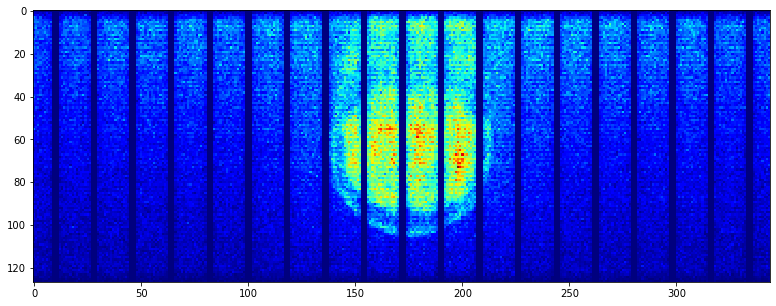

In [10]:
uncompressed_prompts = prompts.uncompress_self()

plt.figure(figsize=(15,5))
plt.imshow(uncompressed_prompts.data[0,5,:,:].T, cmap='jet')

The method `uncompress_self()` produces a new instance of `PET_Projection`, whose data are now uncompressed (and with a new sparsity pattern to keep track of this)

In [13]:
uncompressed_prompts.__class__

tomolab.Reconstruction.PET.PET_projection.PET_Projection

Otherwise, the `to_nd_array()` method achieves a similar results, but it return just a numpy array of the (now) uncompressed projection data, losing any additional information about the Projection itseld (angles, binning, and so on)

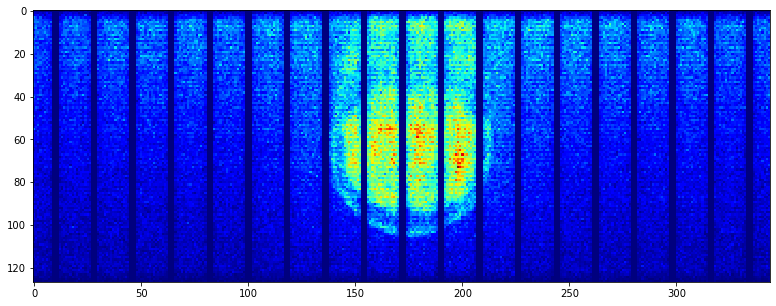

In [12]:
uncompressed_prompts2 = prompts.to_nd_array()

plt.figure(figsize=(15,5))
plt.imshow(uncompressed_prompts2[0,5,:,:].T, cmap='jet')

In [14]:
uncompressed_prompts2.__class__

numpy.ndarray

### Compress a Numpy nd-array

In [6]:
# not yet implemented

### Composition

In [17]:
prompts2 = prompts + prompts

In [18]:
print(f"Are the prompts still compressed?: {prompts2.is_compressed()}")

Are the prompts still compressed?: True


### Extract subsets (uncompressed)

In [19]:
subsets_generator = tomolab.Reconstruction.PET.PET_subsets.SubsetGenerator(prompts.binning.N_azimuthal, prompts.binning.N_axial)
subsets = subsets_generator.new_subset(mode="random",subset_size=8)

In [20]:
uncompressed_prompts_subset = uncompressed_prompts.get_subset(subsets)

print(f'original shape: {uncompressed_prompts.data.shape}')
print(f'compressed shape: {uncompressed_prompts_subset.data.shape}')
# Note: the resulting projection always has dimensions (subset_size, 1, ..,..)
# The first index runs over the projection planes in the subset. 

original shape: (252, 11, 344, 127)
compressed shape: (8, 1, 344, 127)


### Extract subsets (compressed)

In [21]:
prompts_subset = prompts.get_subset(subsets)

In [22]:
print(f'original shape: {prompts.data.shape}')
print(f'compressed shape: {prompts_subset.data.shape}')
# Note: the resulting projection always has dimensions (subset_size, 1, ..,..)
# The first index runs over the projection planes in the subset. 

original shape: (56720650,)
compressed shape: (8, 1, 344, 127)


## Compare the angles list between the whole Projection

In [23]:
prompts.get_angles()

array([[[ 0.        ,  0.01246664,  0.02493327, ...,  3.1041927 ,
          3.1166594 ,  3.129126  ],
        [ 0.        ,  0.01246664,  0.02493327, ...,  3.1041927 ,
          3.1166594 ,  3.129126  ],
        [ 0.        ,  0.01246664,  0.02493327, ...,  3.1041927 ,
          3.1166594 ,  3.129126  ],
        ...,
        [ 0.        ,  0.01246664,  0.02493327, ...,  3.1041927 ,
          3.1166594 ,  3.129126  ],
        [ 0.        ,  0.01246664,  0.02493327, ...,  3.1041927 ,
          3.1166594 ,  3.129126  ],
        [ 0.        ,  0.01246664,  0.02493327, ...,  3.1041927 ,
          3.1166594 ,  3.129126  ]],

       [[-0.482     , -0.482     , -0.482     , ..., -0.482     ,
         -0.482     , -0.482     ],
        [-0.373     , -0.373     , -0.373     , ..., -0.373     ,
         -0.373     , -0.373     ],
        [-0.259     , -0.259     , -0.259     , ..., -0.259     ,
         -0.259     , -0.259     ],
        ...,
        [ 0.259     ,  0.259     ,  0.259     , ...,  

In [24]:
prompts_subset.get_angles()

array([[[ 0.34906584,  0.7978648 ,  0.42386568,  2.85486   ,
          1.8076625 ,  1.1219974 ,  0.03739991,  2.406061  ]],

       [[-0.373     , -0.373     ,  0.        ,  0.        ,
          0.105     ,  0.18      ,  0.259     ,  0.259     ]]],
      dtype=float32)